# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number : 10

## Student 1 
### Name : Vishruty Mittal
### ID : 5584825

## Student 2
### Name : Sayak Mukherjee
### ID : 5222273

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

The code is written on a conda environment with the following packages - numpy, pandas, matplotlib, seaborn, scikit-learn and statsmodel.
The requirements file to create a replica of the enviroment is also provided with this code.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Uncomment for colab

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#Uncomment for colab

# !mkdir data
# !cp '/content/drive/MyDrive/Colab Notebooks/CDA/cda-lab-2.zip' 'data/' # Location of data zipped file
# %cd data/
# !unzip cda-lab-2.zip
# %cd ..

In [4]:
#Uncomment for colab

# %%capture
# !pip install statsmodels --upgrade

In [5]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tqdm import tqdm
from itertools import tee
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [6]:
# Load Data

train_df = pd.read_csv('data/train_data.csv')
test_df = pd.read_csv('data/test_data.csv')
val_df = pd.read_csv('data/val_data.csv')


In [7]:
signal_train_df = train_df.copy()
signal_train_df = signal_train_df.drop(columns=['Id', 'Timestamp', 'Label'], axis = 1)

In [8]:
signal_val_df = val_df.copy()
signal_val_df = signal_val_df.drop(columns=['Id', 'Timestamp', 'Label'], axis = 1)

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [9]:
# get names of the signals

sensors = signal_train_df.columns

In [10]:
datasets = ['train', 'val']

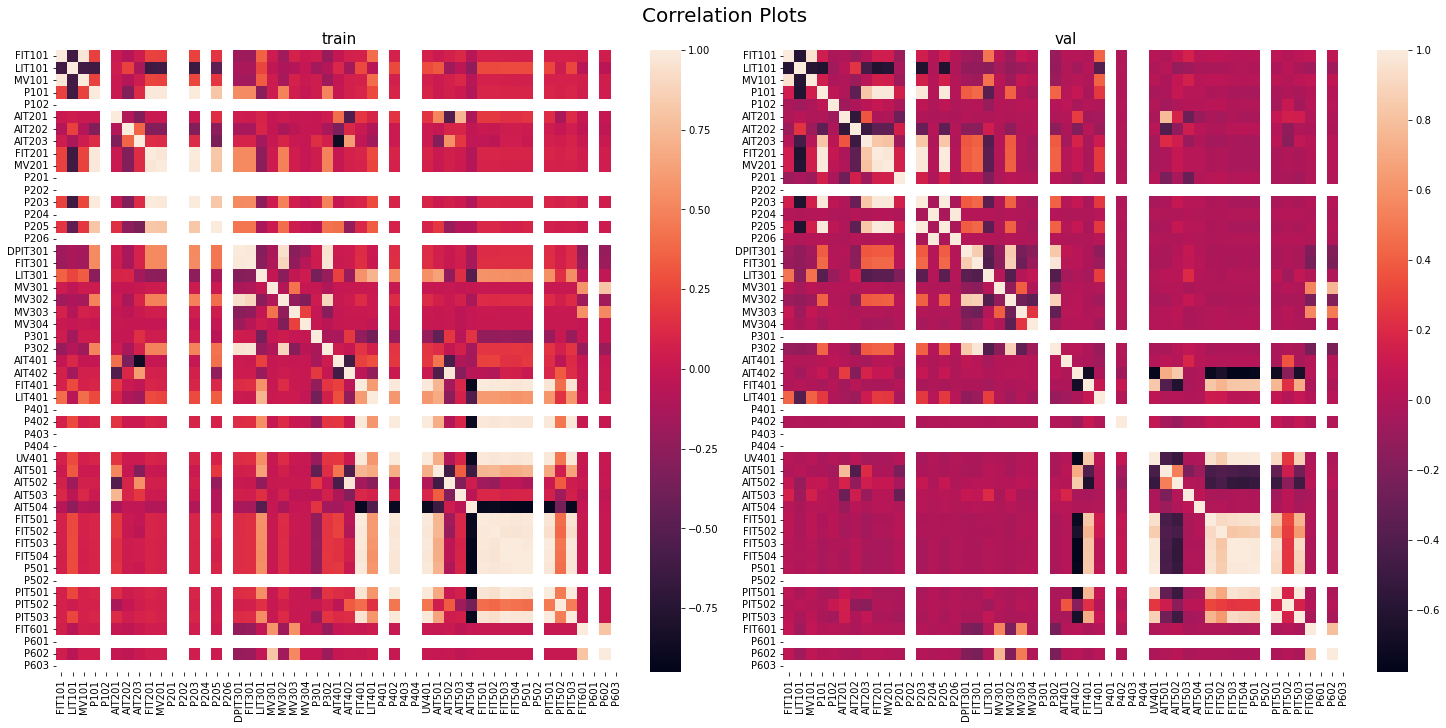

In [11]:
#plotting a correlation matrix

fig, ax = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)

for pos in range(len(datasets)):
    if datasets[pos] == 'train':
        corr = signal_train_df.corr()
    else:
        corr = signal_val_df.corr()

    ax[pos].set_title(datasets[pos], fontsize=15)

    sns.heatmap(corr, 
                ax = ax[pos],
                xticklabels = corr.columns.values, 
                yticklabels = corr.columns.values)
    
fig.suptitle('Correlation Plots', fontsize=20)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:03<00:00, 16.04it/s]


Loading the plots


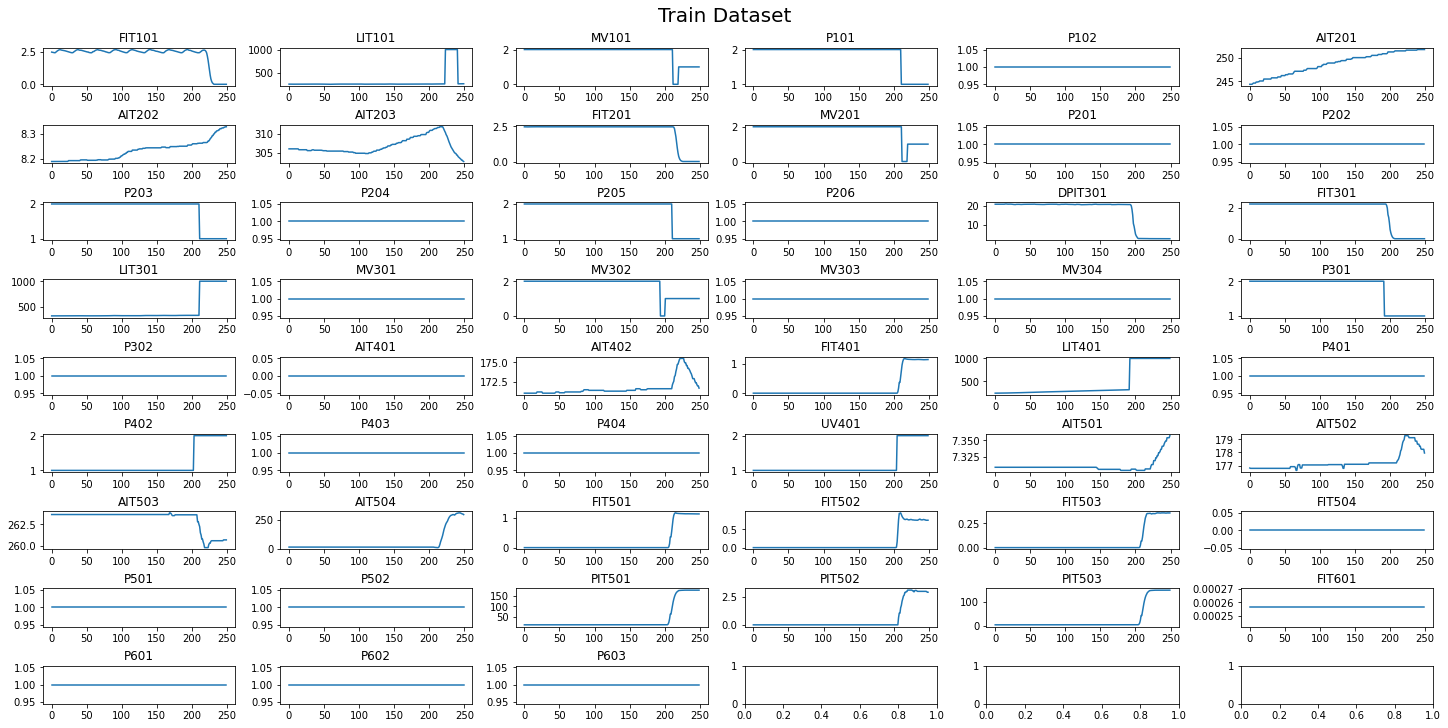

In [12]:
# PLEASE NOTE: Can take time to execute!

# plot segments of each signal
fig, axs = plt.subplots(9, 6, constrained_layout=True)
fig.set_size_inches((20,10))

for i in tqdm(range(len(sensors))):
       a,b = (int(i/6), i%6)
       axs[a,b].plot(range(250), signal_train_df[sensors[i]][0:250])
       axs[a,b].set_title(sensors[i])

fig.suptitle('Train Dataset', fontsize=20)
print("Loading the plots")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 34.84it/s]


Loading the plots


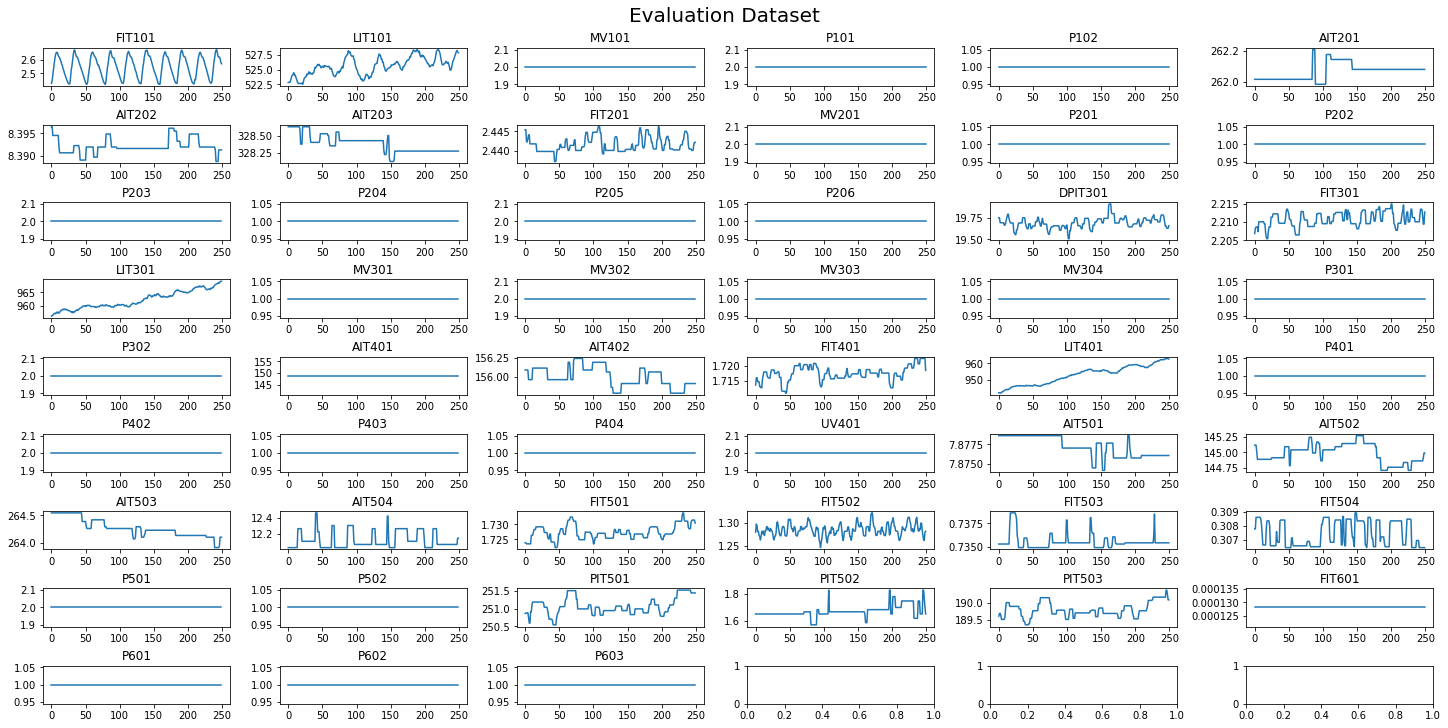

In [13]:
# PLEASE NOTE: Can take time to execute!

# plot segments of each signal
fig, axs = plt.subplots(9, 6, constrained_layout=True)
fig.set_size_inches((20,10))

for i in tqdm(range(len(sensors))):
       a,b = (int(i/6), i%6)
       axs[a,b].plot(range(250), signal_val_df[sensors[i]][0:250])
       axs[a,b].set_title(sensors[i])

fig.suptitle('Evaluation Dataset', fontsize=20)
print("Loading the plots")
plt.show()

### 1b. Answers to the three questions

**1. What types of signals are there?** There are signals corresponding to sensors and actuators. Sensor signals are continuous captured at various components of the system. Actuators are discrete signals signifying turning on and off a particular component.

**2. Are the signals correlated? Do they show cyclic behavior?** Some of the signals are correlated as can be observed in the correlation plots. For example LIT101 is found to be highly correlated with P101. Some of the signals such as FIT502 and LIT101 in the evaluation dataset demonstrates a cyclic behaviour as can be seen from the plots above. 

## 2. LOF task – 1/2 A4 – Sayak Mukherjee

In [14]:
'''
As LOF takes a long time to execute, we had to restrict to implementing
this section only with the sampled data points!!
'''

NUM_SAMPLES = 1000 # number of data points for LOF tasks

In [15]:
# Get a fraction of data points as sample maintaining class distribution

val_X = val_df.drop(['Label'], axis='columns')
val_y = val_df['Label']
col_names = val_df.columns

val_X_benign = val_X[val_y == 0]
val_X_anomaly = val_X[val_y == 1]

num_benign, num_anomaly = int(NUM_SAMPLES/2), int(NUM_SAMPLES/2)

if num_benign > len(val_X_benign):
    num_benign > len(val_X_benign)

if num_anomaly > len(val_X_anomaly):
    num_anomaly > len(val_X_anomaly)
    
frac_benign, frac_anomaly = num_benign/len(val_X_benign), num_anomaly/len(val_X_anomaly)   

val_X = pd.concat([val_X_benign.sample(frac=frac_benign), val_X_anomaly.sample(frac=frac_anomaly)], 
                  ignore_index=True).reset_index(drop=True)

val_y = pd.concat([pd.Series(np.full(num_benign, 0)), 
                   pd.Series(np.full(num_anomaly, 1))], 
                  ignore_index=True).reset_index(drop=True)
                  
val_sample = pd.concat([val_X.reset_index(drop=True), val_y.reset_index(drop=True)], axis=1)
val_sample.columns = col_names

In [16]:
# Sample training datapoints

train_sample = train_df.sample(frac=(NUM_SAMPLES/len(train_df)))

In [17]:
print(f'Train Samples: {train_sample.shape[0]}')
print(f'Validation Samples: {val_sample.shape[0]}')

Train Samples: 1000
Validation Samples: 1000


In [18]:
def normalise_dataframe(dataframe):
    '''
    Wrapper for scikit-learn normalize function
    for handling string columns
    '''

    # take only the non-str columns for normalisation
    col_names = dataframe.columns
    dataframe_str_cols = dataframe[['Id','Timestamp', 'Label']]
    dataframe = dataframe.drop(['Id','Timestamp', 'Label'], axis=1)
    normalized_cols = dataframe.columns

    dataframe = pd.DataFrame(normalize(dataframe, axis=0), columns=normalized_cols)

    dataframe = pd.concat([dataframe.reset_index(drop=True), dataframe_str_cols.reset_index(drop=True)], axis=1)

    return dataframe[col_names]

In [19]:
# As LOF is affected by scale, normalise the features

train_sample  = normalise_dataframe(train_sample)
val_sample = normalise_dataframe(val_sample)

In [20]:
def exec_lof(train_df, test_df, nearest_neighbor, print_perf=True):

    # Fit the LoF model
    lof = LocalOutlierFactor(n_neighbors=nearest_neighbor, 
                             algorithm='ball_tree', 
                             metric='minkowski', 
                             p=2, 
                             contamination="auto", 
                             novelty=True)

    lof.fit(train_df.drop(columns=['Id','Timestamp', 'Label'], axis = 1).values)

    # Fetch predictions and sample scores
    is_inlier = lof.predict(test_df.drop(columns=['Id','Timestamp', 'Label'], axis = 1)) # 1 inlier, -1 outlier
    is_inlier = is_inlier == -1
    is_inlier = is_inlier.astype(float)

    # performance evalutaion
    scores = lof.negative_outlier_factor_

    _, fp, _, tp = confusion_matrix(test_df.Label, is_inlier).ravel()

    if print_perf:

        # Performance Metrics
        print(f'True Positives: {tp}')
        print(f'False Positives: {fp}')
        print(f'F1: {f1_score(test_df.Label, is_inlier)}')
        print(f'Precision: {precision_score(test_df.Label, is_inlier)}')
        print(f'Recall: {recall_score(test_df.Label, is_inlier)}')
        print(f'Accuracy: {accuracy_score(test_df.Label, is_inlier)}')

    return lof, is_inlier, scores, (fp, tp)

In [21]:
# PLEASE NOTE: Each run takes a LONG time for larger samples
# Hence it was run on only limited data points. 
# Thus we did not any noticeable performance gain

# Commented for performance reasons.

# for tuning the nearest neighbor hyper-parameter
nns = [nn for nn in range(1, 300)]
fps = []
tps = []

for nn in tqdm(nns):
    _, _, _, (exec_fp, exec_tp) = exec_lof(train_sample, val_sample, nearest_neighbor = nn, print_perf = False)
    fps.append(exec_fp)
    tps.append(exec_tp)

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [01:18<00:00,  3.80it/s]


<AxesSubplot:xlabel='Nearest Neighbours'>

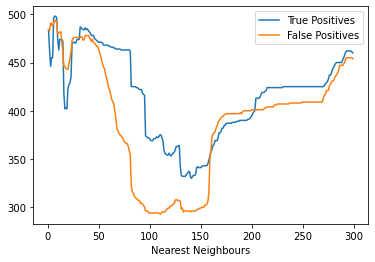

In [22]:
# plot performance for each value of nearest neighbour

plot_df = pd.DataFrame({"True Positives": tps, "False Positives": fps, "Nearest Neighbours": nns})
sns.lineplot(x="Nearest Neighbours", y=tps, data=plot_df, legend='brief', label="True Positives")
sns.lineplot(x="Nearest Neighbours", y=fps, data=plot_df, legend='brief', label="False Positives")

In [23]:
def remove_outliers(model, dataframe):
    '''
    Removes outliers within the train data
    '''

    is_inlier = model.predict(dataframe.drop(columns=['Id','Timestamp', 'Label'], axis = 1)) # 1 inlier, -1 outlier
    is_inlier = is_inlier == -1
    is_inlier = is_inlier.astype(float)

    drop_indices = np.where(is_inlier == 1)[0]
    dataframe = dataframe.drop(dataframe.index[drop_indices], axis=0)
    dataframe = dataframe.reset_index(drop=True)

    return dataframe, drop_indices, is_inlier

### 2a. Plot LOF scores

In [24]:
print('Without Cleaning')
lof_model, _, scores, _ = exec_lof(train_sample, val_sample, nearest_neighbor = 160)

Without Cleaning
True Positives: 358
False Positives: 359
F1: 0.5883319638455218
Precision: 0.499302649930265
Recall: 0.716
Accuracy: 0.499


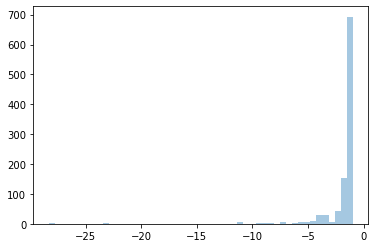

In [25]:
sns.distplot(scores, kde=False)
plt.show()

In [26]:
train_sample_clean, outliers_lof, labels = remove_outliers(lof_model, train_sample)

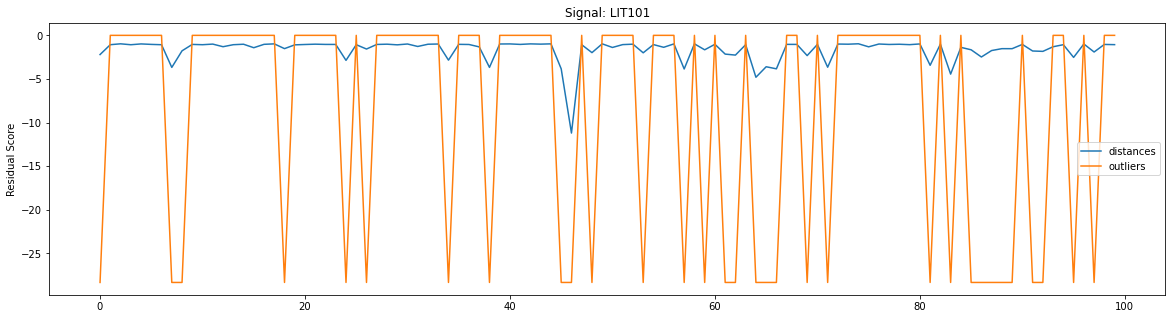

In [27]:
labels[outliers_lof] = min(scores)

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(scores[0:100], label='distances')
ax.plot(labels[0:100], label='outliers')
plt.title('Signal: LIT101')
plt.ylabel('Residual Score')
plt.legend()
plt.show()

In [28]:
print('With Cleaning')
_, _, scores, _ = exec_lof(train_sample_clean, val_sample, nearest_neighbor = 160)

With Cleaning
True Positives: 388
False Positives: 404
F1: 0.6006191950464396
Precision: 0.4898989898989899
Recall: 0.776
Accuracy: 0.484


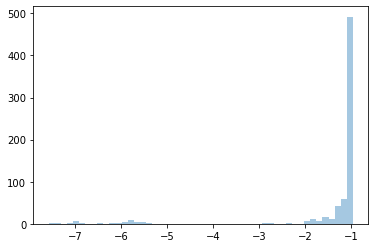

In [29]:
sns.distplot(scores, kde=False)
plt.show()

### 2b. Analysis and answers to the questions

**1. Do you see large abnormalities in the training data?** Yes, there are some data points in the training  dataset that are considered anomalous by Local Outlier Factor detection.

**2. Can you explain why these occur?** The  Local Outlier Factor measures the local deviation of the density of a given sample with respect to its neighbors. Some of the data points in the training data deviates considerable from the local density of all the training samples. The same can be seen in plot above with the residual scores plotted. These deviations can occur from a varied variety of reasons such as variations in the sensor readings and environment noise.

**3. Describe the kind of anomalies you can detect using LOF** LOF can be used to detect *point anomalies* by comparing the deviation of a particular data point density when compared to its neighbours. 


## 3. PCA task – 1/2 A4 – Vishruty Mittal




In [30]:
# Perform PCA and calculate train and validation residuals

def residuals_pca(train_df, val_df, n_components):
  # Normalize the features
  scaling = StandardScaler()
  scaling.fit(train_df)
  scaled_train_data = scaling.transform(train_df)
  scaled_val_data = scaling.transform(val_df)

  #Perform PCA and evaluate back projections for both train and validation set
  pca = PCA(n_components=n_components)
  pca.fit(scaled_train_data)
  train_pca = pca.transform(scaled_train_data)
  train_proj_back = pca.inverse_transform(train_pca)
  val_pca = pca.transform(scaled_val_data)
  val_proj_back = pca.inverse_transform(val_pca)

 # calculating residuals by substracting actual value from predicted value
  train_residuals = np.subtract(scaled_train_data,train_proj_back)
  val_residuals = np.subtract(scaled_val_data,val_proj_back)

  # combine point wise residuals
  train_residuals = np.sqrt(np.sum(np.square(train_residuals),axis=1))
  val_residuals = np.sqrt(np.sum(np.square(val_residuals),axis=1))

  return train_residuals, val_residuals, pca


In [31]:
_,_, pca = residuals_pca(signal_train_df, signal_val_df, 51)
pca.explained_variance_ratio_.cumsum()

array([0.31492694, 0.48833361, 0.5921172 , 0.68939688, 0.75429756,
       0.80150503, 0.83431651, 0.86477116, 0.88749357, 0.90757968,
       0.92529928, 0.93907649, 0.95156597, 0.9615642 , 0.97101308,
       0.97560059, 0.97928821, 0.98287105, 0.98577605, 0.9885912 ,
       0.99107927, 0.99297266, 0.99431566, 0.99553993, 0.99650872,
       0.99720921, 0.9978208 , 0.99836412, 0.99888902, 0.99917473,
       0.99938028, 0.9995369 , 0.99968991, 0.99980539, 0.99990794,
       0.99996903, 0.99998699, 0.99999629, 0.99999931, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

**OBSERVATION:** This means the first 20 components out of the total 51 in the dataset can describe almost 99% of the variance in dataset.

In [32]:
# Run PCA and plot residual graphs for train and test
 
def pca_plots(signal_train_df, signal_val_df, n_components):
  train_residuals, eval_residuals,_ = residuals_pca(signal_train_df, signal_val_df, n_components)

  plt.plot(train_residuals,'g')
  plt.legend(['Training Data'])
  plt.show()

  plt.plot(eval_residuals)
  plt.legend(['Training Evaluation Data'])
  plt.show()

  return train_residuals, eval_residuals


In [33]:
#Evaluate PCA by calculating precision, recall and F1 metrics

def pca_eval(train_residuals, eval_residuals):

  '''The threshold values can be further tuned to improve the performance.
    Much effort has not been put into the same as it is not the intent of the course 
  '''
  max_threshold = max(train_residuals) - 4
  min_threshold = min(train_residuals) + 0.2

  pca_anomalies = (np.where((eval_residuals > max_threshold) | (eval_residuals < min_threshold)))[0]
  forecasts = np.zeros((eval_residuals.shape[0],), dtype=int)

  for idx in pca_anomalies:
    forecasts[idx] = 1

  tn, fp, fn, tp = confusion_matrix(val_df.Label, forecasts).ravel()

  # Performance Metrics
  print(f'True Positives: {tp}')
  print(f'False Positives: {fp}')
  print(f'True Negatives: {tn}')
  print(f'False Negatives: {fn}')
  print(f'F1: {f1_score(val_df.Label, forecasts)}')
  print(f'Precision: {precision_score(val_df.Label, forecasts)}')
  print(f'Recall: {recall_score(val_df.Label, forecasts)}')
  print(f'Accuracy: {accuracy_score(val_df.Label, forecasts)}')




### 3a. Plot PCA residuals

Plotting residuals with different number of components

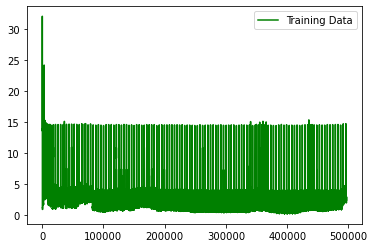

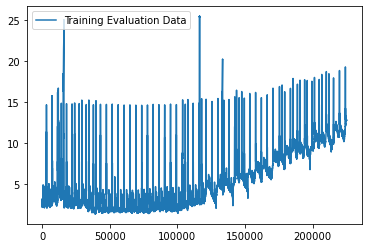

True Positives: 0
False Positives: 0
True Negatives: 213923
False Negatives: 11036
F1: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.950942171684618


In [34]:
# n_components = 10
train_residuals, val_residuals = pca_plots(signal_train_df, signal_val_df, 10)
pca_eval(train_residuals, val_residuals)

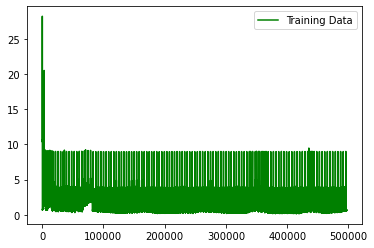

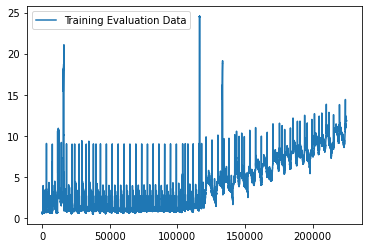

True Positives: 372
False Positives: 20
True Negatives: 213903
False Negatives: 10664
F1: 0.06510325516275814
Precision: 0.9489795918367347
Recall: 0.033707865168539325
Accuracy: 0.9525069012575625


In [35]:
# n_components = 15
train_residuals, val_residuals = pca_plots(signal_train_df, signal_val_df, 15)
pca_eval(train_residuals, val_residuals)

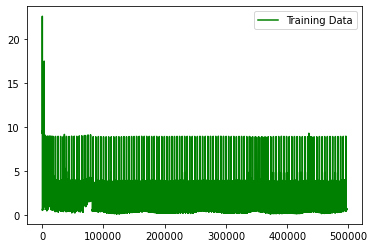

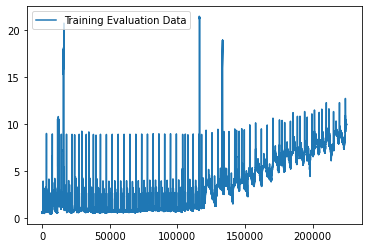

True Positives: 465
False Positives: 20
True Negatives: 213903
False Negatives: 10571
F1: 0.08072215953476261
Precision: 0.9587628865979382
Recall: 0.042134831460674156
Accuracy: 0.9529203099231416


In [36]:
# n_components = 17
train_residuals, val_residuals = pca_plots(signal_train_df, signal_val_df, 17)
pca_eval(train_residuals, val_residuals)

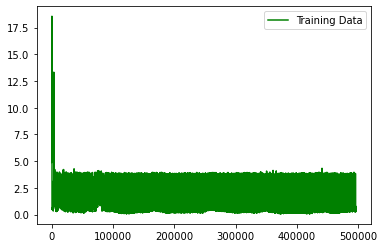

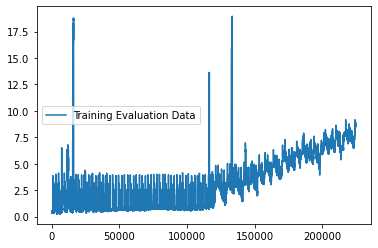

True Positives: 938
False Positives: 19
True Negatives: 213904
False Negatives: 10098
F1: 0.1564245810055866
Precision: 0.9801462904911181
Recall: 0.08499456324755346
Accuracy: 0.9550273605412541


In [37]:
# n_components = 20
train_residuals, val_residuals = pca_plots(signal_train_df, signal_val_df, 20)
pca_eval(train_residuals, val_residuals)


REMARK: n_components has been selected as 20 as it describes almost 99% of the variance in the data and has lowest residual values (in validation set) as seen in the plots above.

### 3b. Removing anomalies from train data - PCA




In [38]:
# Determine indices of top k anomalies in train set by examoning train_residuals
def top_k_residuals(train_residuals, k):
  ind = np.argpartition(train_residuals, -k)[-k:]
  return np.sort(ind)

In [39]:
# Removing top k anomalies and then using PCA with modified data 
def remove_train_anomalies_then_pca(train_residuals, signal_train_df , k):


  anomaly_indexes_train = top_k_residuals(train_residuals, k)
  print("Indices of top ", k , " anomalies are: ", anomaly_indexes_train )

  # Remove these anomaly points from training data
  print("Original train df shape ",signal_train_df.shape)

  modified_signal_train_df = signal_train_df.drop(anomaly_indexes_train, axis = 0)
  modified_signal_train_df.reset_index(drop=True, inplace=True)

  print("Modified train df shape ",modified_signal_train_df.shape)

  train_residuals, eval_residuals = pca_plots(modified_signal_train_df, signal_val_df, 20 )
  pca_eval(train_residuals, eval_residuals)

  return train_residuals, eval_residuals, modified_signal_train_df, anomaly_indexes_train


Indices of top  10  anomalies are:  [203 204 205 206 207 208 209 210 211 212]
Original train df shape  (496800, 51)
Modified train df shape  (496790, 51)


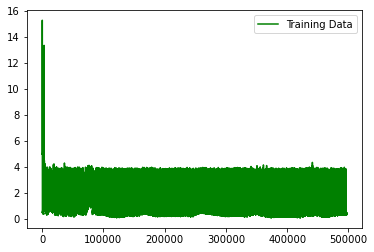

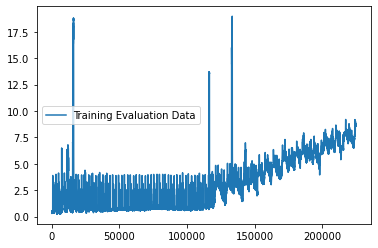

True Positives: 1396
False Positives: 58
True Negatives: 213865
False Negatives: 9640
F1: 0.2235388310648519
Precision: 0.9601100412654745
Recall: 0.1264951069227981
Accuracy: 0.9568899221635943


In [40]:
# Takes residuals obtained from the above run where n_components = 20
# Remove top 10 anomalies in train set and then perform pca and evaluation

train_residuals, eval_residuals, modified_signal_train_df, rows_deleted = remove_train_anomalies_then_pca(train_residuals, signal_train_df , 10)

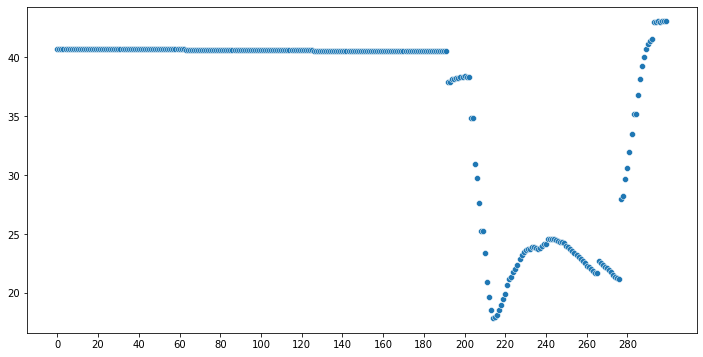

In [41]:
# Plot the train data as 1 feature (n_component=1) to visualize anomaly in reference to other points
def plot_pca(signal_train_df, start, end):
  scaling = StandardScaler()
  scaling.fit(signal_train_df)
  scaled_train_data = scaling.transform(signal_train_df)

  pca = PCA(n_components = 1)
  pca.fit(scaled_train_data)

  train_pca = pca.transform(scaled_train_data)

  plt.figure(figsize = (12,6))
  plt.xticks(range(start,end,20))
  sns.scatterplot(range(start, end), train_pca[start: end].reshape(-1))

'''
The above print statement showed 
Indices of top 10 anomalies in train_data :  [203 204 205 206 207 208 209 210 211 212]
Thereby plotting train set [0:300] to visualize these points in reference to other data points
'''

train_pca = plot_pca(signal_train_df, 0,300)


### 3c. Analysis and answers to the questions


**1. Do you see large abnormalities in the training data?** Yes, there are some data points in the training dataset that are considered anomalous by PCA. As seen in the above 1D plot(n-components = 1), some data points are very different than others which have also been termed as anomaly by analysing the train residual plots. 

**2. Can you explain why these occur?** PCA analyzes variance in the data and then chooses the directions of higher variance as principal components. So for some data points this variance in principal components is much higher/lower than the other points which make them an anomaly. These deviations can occur from a varied variety of reasons such as variations in the sensor readings and environment noise.

**3. Describe the kind of anomalies you can detect using PCA** PCA can be used to detect *point anomalies* by comparing the principal components of a point with the other data points. 

## 4. AR task – 1/2 A4 - Vishruty Mittal

In [42]:
# Perform regression and determine forecasts and residuals for validation set
def perform_AutoReg(slicing_window_length, number_predictions, train_data, validation_data, flag =0, plot_needed=True):

 '''
  REF: https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html
       https://towardsdatascience.com/how-to-use-an-autoregressive-ar-model-for-time-series-analysis-bb12b7831024

  slicing_window_length: The sliding window length/number of lags to include in the model 
  number_predictions: Number of predictions to be made
  train_data: Training data to train the model (values of the signal in training set)
  validation_data: Sensor values in validation data (Only used to calculate validation residual)
  flag: Check if it is differenced or not
 '''
 
 # Autoreg uses linear regression to fit the data points inside the slicing window 
 model = AutoReg(train_data, lags = slicing_window_length).fit()
 # Using the trained regression model, predict future  values
 forecasts = model.forecast(number_predictions)

 if flag == 0:
   AutoReg_residual = validation_data - forecasts
 else:
    AutoReg_residual = validation_data - forecasts[1:]
 if plot_needed:
    plt.plot(AutoReg_residual,'g')
    plt.xlabel("Future time steps")
    plt.ylabel("Residual value")
    plt.show()

 return AutoReg_residual, forecasts

In [43]:
#Code for differencing train and validation data of a signal

def signal_differencing(signal):
  differenced_train_signal = []
  differenced_val_signal = []

  for i in range(1, train_df.shape[0]):
    differenced_train_signal.append(train_df[signal][i] - train_df[signal][i-1])

  for i in range(1,  val_df.shape[0]):
    differenced_val_signal.append(val_df[signal][i] - val_df[signal][i-1])
  
  return differenced_train_signal, differenced_val_signal



In [44]:
# Determine confusion matrix for a signal comparing the predicted labels and actual labels

def evaluate_AR(predicted_label, actual_label):

  true_positive = 0
  false_positive = 0
  true_negative = 0
  false_negative = 0

  for record in range(0,len(predicted_label)):
    if (actual_label[record] == 1 & predicted_label[record]==1):
      true_positive +=1
    if (actual_label[record] == 0 & predicted_label[record]==0):
      true_negative +=1
    if (actual_label[record] == 1 & predicted_label[record]==0):
      false_negative +=1
    if (actual_label[record] == 0 & predicted_label[record]==1):
      false_positive +=1
    
  if (true_positive + false_positive) ==0:
    precision = "N/A, as no positive cases found"
  else:
    precision = true_positive / (true_positive + false_positive)
  if (false_positive + false_negative) ==0:
    recall = "N/A, as no false predictions found"
  else:
    recall = true_positive / (false_positive + false_negative)
  if ((true_positive + false_positive !=0) and (false_positive + false_negative !=0)):
    f1 = 2*precision*recall / (precision + recall)
  else:
    f1 = "N/A"

  print("True positive ", true_positive)
  print("True negative", true_negative)
  print("False positive ", false_positive)
  print("False negative ", false_negative)
  print("Precision ", precision)
  print("Recall ", recall)
  print("F1 score" , f1)


### 4a. Print relevant plots and/or metrics to determine the parameters.

### Signal LIT101

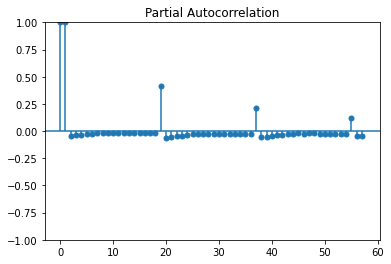

In [45]:
# Partial auto-correlation plot for signal LIT301
signal = train_df['LIT101'].to_numpy()
plot_pacf(signal);

**OBSERVATION**: The above plot suggests the length of sliding window as 2





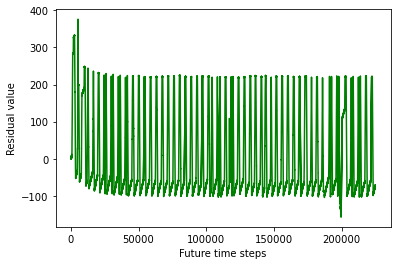

In [46]:
#Residual plot when sliding window is of length 2
_,_ = perform_AutoReg(2, val_df.shape[0], train_df['LIT101'].to_numpy(), val_df['LIT101'].to_numpy())

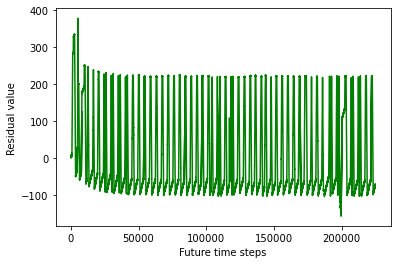

In [47]:
#Residual plot when sliding window is of length 20
_,_ = perform_AutoReg(20, val_df.shape[0], train_df['LIT101'].to_numpy(), val_df['LIT101'].to_numpy())

**OBSERVATION**: Plotted the result of regression for two sliding windows: 2 (as suggested by partial auto-correlation plot) and 20 and no significant difference can be seen.

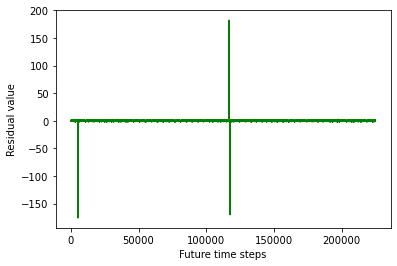

In [48]:
# Residual plot for the differenced LIT101 signal

differenced_train_signal_LIT101, differenced_val_signal_LIT101 = signal_differencing('LIT101')
residual_value_LIT101, forecasts_LIT101  = perform_AutoReg( 2, val_df.shape[0], differenced_train_signal_LIT101, differenced_val_signal_LIT101, 1)



### Plots to study the detected anomalies

In [49]:
# As per the above plot, data points for which residual>50 or is <50 can be considered anomolous
indices = np.where((residual_value_LIT101 < -50) | (residual_value_LIT101 > 50))
print("Anomolous points according to signal LIT101",indices[0])

forecasted_anomaly_LIT101 = np.zeros((residual_value_LIT101.shape[0],), dtype=int)

for idx in indices[0]:
  forecasted_anomaly_LIT101[idx] = 1

# Print the confusion matrix for predictions for the signal LIT101
evaluate_AR(forecasted_anomaly_LIT101, val_df['Label'][1:].to_numpy())

Anomolous points according to signal LIT101 [  5282 116998 117700]
True positive  2
True negative 213922
False positive  0
False negative  213921
Precision  1.0
Recall  9.34924574959915e-06
F1 score 1.869831668404052e-05


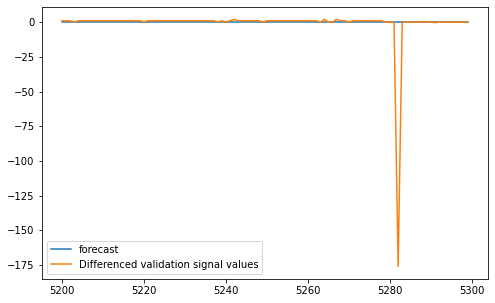

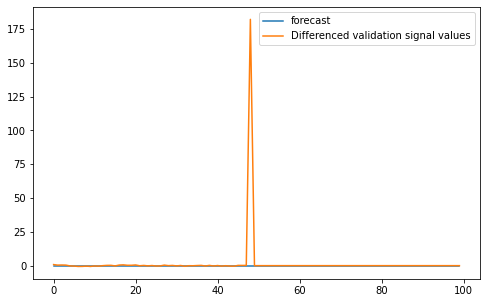

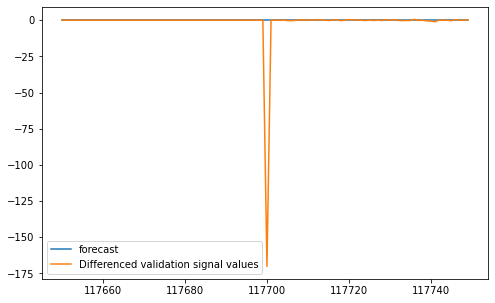

In [50]:
# Plot the anomalies found in signal LIT101

plt.figure(figsize=(8, 5))
plt.plot( range(5200, 5300), forecasts_LIT101[5200:5300] , label = "forecast")
plt.plot( range(5200, 5300),differenced_val_signal_LIT101[5200:5300] , label = "Differenced validation signal values")
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))
plt.plot( forecasts_LIT101[116950 : 117050] , label = "forecast")
plt.plot( differenced_val_signal_LIT101[116950 : 117050] , label = "Differenced validation signal values")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(117650, 117750), forecasts_LIT101[117650 : 117750] , label = "forecast")
plt.plot(range(117650, 117750),differenced_val_signal_LIT101[117650 : 117750] , label = "Differenced validation signal values")
plt.legend()
plt.show()



### Signal FIT301

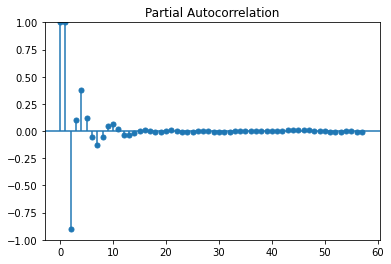

In [51]:
# Partial auto-correlation plot for signal FIT301
signal = train_df['FIT301'].to_numpy()
plot_pacf(signal);

**OBSERVATION**: The above plot suggests the length of sliding window as 3

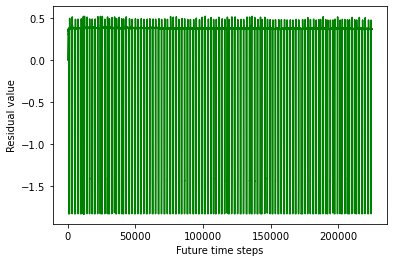

In [52]:
#Residual plot when sliding window is of length 3
_,_ = perform_AutoReg(3, val_df.shape[0], train_df['FIT301'].to_numpy(), val_df['FIT301'].to_numpy())

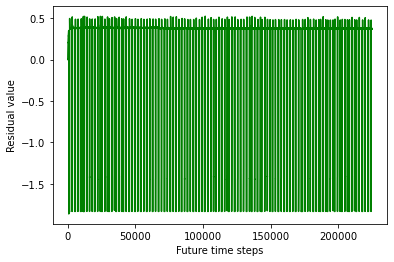

In [53]:
#Residual plot when sliding window is of length 20
_,_ = perform_AutoReg(20, val_df.shape[0], train_df['FIT301'].to_numpy(), val_df['FIT301'].to_numpy())

**OBSERVATION**: Plotted the result of regression for two sliding windows: 3 (as suggested by partial auto-correlation plot) and 20 and no significant difference can be seen.

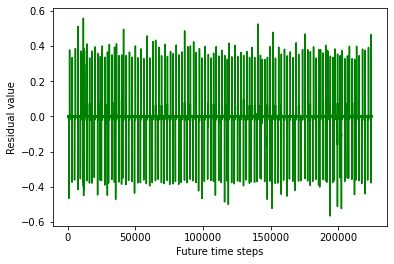

In [54]:
# Residual plot for the differenced data
differenced_train_signal_FIT301, differenced_val_signal_FIT301 = signal_differencing('FIT301')
residual_value_FIT301, forecasts_FIT301 = perform_AutoReg( 3, val_df.shape[0], differenced_train_signal_FIT301, differenced_val_signal_FIT301, 1)

**OBSERVATION**: The residual values post differencing are lesser than in comparison to the plot without differencing

In [55]:
# As per the above plot, data points for which residual>0.5 or is <-0.5 can be considered anomolous

indices = np.where((residual_value_FIT301 < -0.5) | (residual_value_FIT301 > 0.5))
print("Anomolous points according to signal FIT301",indices[0])

forecasted_anomaly_FIT301 = np.zeros((residual_value_FIT301.shape[0],), dtype=int)

for idx in indices[0]:
  forecasted_anomaly_FIT301[idx] = 1

evaluate_AR(forecasted_anomaly_FIT301, val_df['Label'][1:].to_numpy())

Anomolous points according to signal FIT301 [  7571  11506 118665 140479 150964 193954 199292 202235]
True positive  2
True negative 213922
False positive  0
False negative  213916
Precision  1.0
Recall  9.349464275697002e-06
F1 score 1.8698753728064025e-05


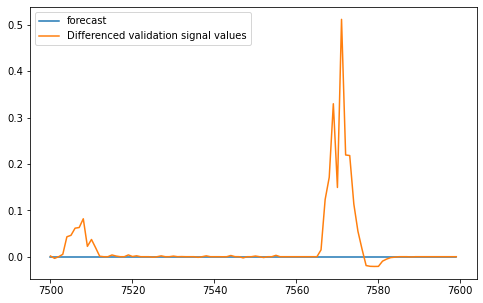

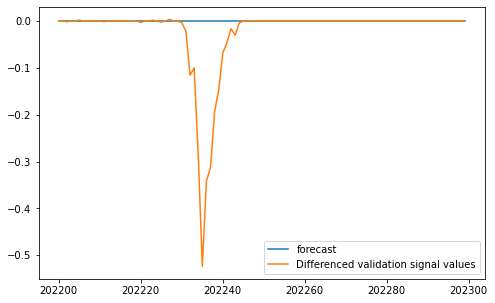

In [56]:
# Plot the anomalies found in signal FIT301

plt.figure(figsize=(8, 5))
plt.plot( range(7500, 7600), forecasts_FIT301[7500 : 7600] , label = "forecast")
plt.plot( range(7500, 7600),differenced_val_signal_FIT301[7500: 7600] , label = "Differenced validation signal values")
plt.legend()
plt.show()


plt.figure(figsize=(8, 5))
plt.plot( range(202200, 202300), forecasts_FIT301[202200 : 202300] , label = "forecast")
plt.plot( range(202200, 202300), differenced_val_signal_FIT301[202200 : 202300] , label = "Differenced validation signal values")
plt.legend()
plt.show()


### Multivariate Analysis

In [57]:
# Please NOTE this can take time to execute

def AR_multivariate_predict(train_dataframe, test_dataframe, column_list=None):
    '''
    predicts labels based on each signal
    '''
   
    pred_per_col = {}
    metric_per_col = {}
    
    for col in tqdm(column_list):

      differenced_train_signal, differenced_val_signal = signal_differencing(col)
      residual_value, forecasts = perform_AutoReg( 50, val_df.shape[0], differenced_train_signal, differenced_val_signal, 1, False)
      residual_mean = residual_value.mean()
      residual_std = residual_value.std()

      indices = np.where((residual_value < (residual_mean - 2* residual_std)) | (residual_value > (residual_mean + 2* residual_std)))

      pred_signal = np.zeros((residual_value.shape[0],), dtype=int)

      for idx in indices[0]:
        pred_signal[idx] = 1
      
      pred_per_col[col] = pred_signal

      metric_per_col[col] = {}
      _, fp, _, tp = confusion_matrix(test_dataframe.Label[1:], pred_signal).ravel()

      metric_per_col[col]['fp'] = fp
      metric_per_col[col]['tp'] = tp
      metric_per_col[col]['F1'] = f1_score(test_dataframe.Label[1:], pred_signal)
      metric_per_col[col]['Precision'] = precision_score(test_dataframe.Label[1:], pred_signal)
      metric_per_col[col]['Recall'] = recall_score(test_dataframe.Label[1:], pred_signal)
      metric_per_col[col]['Accuracy'] = accuracy_score(test_dataframe.Label[1:], pred_signal)

        
    return pd.DataFrame(pred_per_col), pd.DataFrame(metric_per_col)

In [58]:
preds, perf = AR_multivariate_predict(train_df, val_df, column_list=sensors)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [19:27<00:00, 22.89s/it]


In [59]:
# Aggregate results such that if atleast one of the signal states anomaly the datapoint is marked anomalous 

max_pred = preds.aggregate('max', axis=1)

_, fp, _, tp = confusion_matrix(val_df.Label[1:], max_pred).ravel()

# Performance Metrics
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'F1: {f1_score(val_df.Label[1:], max_pred)}')
print(f'Precision: {precision_score(val_df.Label[1:], max_pred)}')
print(f'Recall: {recall_score(val_df.Label[1:], max_pred)}')
print(f'Accuracy: {accuracy_score(val_df.Label[1:], max_pred)}')

True Positives: 5238
False Positives: 85936
F1: 0.10249486351628999
Precision: 0.05745058898370149
Recall: 0.47462848858281986
Accuracy: 0.5922172138799242


### 4c. Analysis and answers to the questions

**1. Does the autocorrelation analysis agree with the obtained results? Explain why.** Yes the window size/lag value suggested by partial auto-correlation curves for both the sensors holds as when compared with higher lags, residual plots do not change. It is because partial correlation curve already informs about which timesteps are correlated with the current timestep.

**2. Does the predictive performance increase after differencing? Explain why**
Yes, on differencing the predictive performance increases. It can be seen that the residual values in differenced plots is less in comparison to the plots without differencing. This signifies that the sensor values can be predicted more accurately after differencing. This is because differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

**3. What kind of anomalies can you detect using linear regression models?**
Linear regression models can be used to detect contextual anomalies where a point is considered anomalous in a particular context.

**4. Which kind of sensors can be modeled effectively using linear regression?**
Linear regression would be useful in the scenarios where sensor value or change in sensor value is linear with time. In such scenarios, spike or a sudden trough would clearly signify an anomaly.

## 5. N-gram task – 1/2 A4 - Sayak Mukherjee

In [60]:
# Global variable

TRAIN_SIGNATURES = []

MAX = 0.0
MIN = 0.0
BINS = None
APLHABETS = None

In [61]:
# ref: https://johannfaouzi.github.io/pyts/_modules/pyts/quantization/quantization.html#SAX

def discretise(signal, is_train=True, quantiles='linspace', levels=3):
    '''
    Discretise signal within levels
    '''
    
    global MIN, MAX, BINS, APLHABETS
    
    is_failed = False

    # normalise
    if is_train:
        MIN = signal.min()
        MAX = signal.max()

    signal = (signal - MIN) / (MAX - MIN)
    
    if MAX == MIN:
        is_failed = True
        
        # constant value signal
        return None, None, None, is_failed
    
    if is_train:
        
        # initialise the global variables
        
        APLHABETS = np.array([chr(i) for i in range(97, 97 + levels)])
        
        # insert additional character at starting and end to encode unseen values
        APLHABETS = np.insert(APLHABETS, 0, 'X')              
        APLHABETS = np.insert(APLHABETS, len(APLHABETS), 'X')
        
        if quantiles == 'linspace':
            BINS = np.linspace(0., 1., levels + 1)
        else:
            BINS = np.percentile(signal, np.linspace(0, 100, levels + 1))
            
        BINS[-1] += 1e-5 

    indices = np.array([np.digitize(signal, BINS)])
    
    coded_signals = APLHABETS[indices] # coded signal
    
    # handling for unseen values during test
    value_beyond_lim = np.where(indices == len(BINS))[0]
    
    if is_train:
        if len(value_beyond_lim) > 0:
            print(f'Incorrect Values')
    else:
        
        # since it will only be used for plotting here onwards
        # map back any point that falls outside the bins to the 
        # last bin
        
        indices[value_beyond_lim] = len(BINS) - 1
    
    try:
        discrete_signals = BINS[indices] # discretised signal
    except:
        print(indices)

    return  signal, coded_signals[0], discrete_signals[0], is_failed

In [62]:
# ref: https://www.nltk.org/_modules/nltk/util.html

def generate_n_grams(data_seq, n=0):
    '''
    generates all possible n-grams within a sequence 
    '''
    
    iterables = tee(data_seq, n)

    for i, sub_iterable in enumerate(iterables):  
        for _ in range(i):
            next(sub_iterable, None)
    
    # convert to strings 
    
    ngrams_seq = []
    
    for val in zip(*iterables) :
        n_gram_str = ''.join(val)
        
        ngrams_seq.append(n_gram_str)
            
    return ngrams_seq

In [63]:
def calc_freq(signal, is_train=True, window=3, overlap=0, n=2):
    '''
    calculate frequency of each n-gram within a window
    '''
    
    global TRAIN_SIGNATURES 
    
    signature = {} # dictinary with window index as key and ngram frequency as value
    
    # loop over all the windows
    
    start_pos = 0 
    window_count = 0
    
    while start_pos + window < len(signal):
        
        end_pos = start_pos + window
        
        ngrams_seq = generate_n_grams(signal[start_pos:end_pos], n) # generate ngrams 
        
        unique_vals, counts = np.unique(ngrams_seq, return_counts=True) # count frequency of each ngram
        
        curr_window = dict(zip(unique_vals, counts)) # dictionary with ngram as key and count as value
        
        if not is_train:
            
            signature[window_count] = {}
            
            # Remove freq for n_grams not in train set
            for key in TRAIN_SIGNATURES:
                if key in curr_window.keys():
                    signature[window_count][key] = curr_window[key]
        else:
            
            signature[window_count] = curr_window
        
        window_count += 1
        
        start_pos = end_pos - overlap
        
    signature_df = pd.DataFrame(signature).T
    signature_df.fillna(0, inplace=True)
    
    n_sample, _ = signature_df.shape
    
    # get frequency of same ngrams in both train and test sets
    if not is_train:
        
        missing_col_names  = list(set(TRAIN_SIGNATURES) - set(list(signature_df.columns)))  
        
        if len(missing_col_names) > 0:
            missing_cols = dict(zip(missing_col_names, [np.zeros(n_sample)]*len(missing_col_names)))
        
            signature_df = pd.concat([signature_df.reset_index(drop=True), 
                                      pd.DataFrame(missing_cols).reset_index(drop=True)], 
                                     axis = 1)

            signature_df = signature_df[TRAIN_SIGNATURES]
        
    else:
        TRAIN_SIGNATURES = []
        TRAIN_SIGNATURES = list(signature_df.columns)
    
    return signature_df

In [64]:
def predictions(train_signatures, test_signatures, pred_signal, threshold = 0.04, derive_threshold = False):
    '''
    predicts whether each window in test set is anomalous
    '''
    
    neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
    neigh.fit(train_signatures.values)
    
    # find distances to the nearest neigbour
    distances, _ = neigh.kneighbors(test_signatures.values, return_distance = True)
    
    if derive_threshold:
        threshold = np.percentile(distances, threshold)
    
    # mark anomalous if distance more than threshold
    anomalous = np.where(distances.reshape(-1) > threshold)
    
    # map back from windows to data points
    for window_count in anomalous[0]:

        start_pos = (WINDOW * window_count) - (OVERLAP * window_count)

        end_pos = start_pos + WINDOW

        pred_signal[start_pos:end_pos] = 1
    
    return distances, pred_signal

### 5a. Visualise discretization

#### Signal: LIT101

In [65]:
# hyperparameters for 'LIT101'

N = 4 
LEVELS = 10
WINDOW = 1000
OVERLAP = 0
THRESHOLD = 0.04 # decided based on the nearest neighbor distance plot found below
QUANTILES = 'linspace' # can be 'linspace' or 'percentiles'

In [66]:
# train set

signal = train_df[['LIT101']].values
signal = signal.reshape(-1)

norm_signal, coded_signal, discrete_signal, _ = discretise(signal, quantiles=QUANTILES,  levels=LEVELS)

signature = calc_freq(coded_signal, window=WINDOW, overlap=OVERLAP, n=N)

In [67]:
# table showing windows in rows and ngrams in columns

signature.head() # only head printed for efficiency

,aaaa,baaa,bbaa,bbba,bbbb,bbbj,bbjj,bjjj,jbbb,jjbb,...,efef,feff,gghg,ghgh,hghh,efee,fefe,ffef,ghhg,hhgh
0,371.0,1.0,1.0,1.0,602.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,589.0,0.0,0.0,0.0,405.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,997.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,997.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# validation set

val_signal = val_df[['LIT101']].values
val_signal = val_signal.reshape(-1)

norm_signal_v, coded_signal_v, discrete_signal_v, _ = discretise(val_signal, quantiles=QUANTILES, is_train = False, levels=LEVELS)

val_signature = calc_freq(coded_signal_v, is_train = False, window=WINDOW, overlap=OVERLAP, n=N)

In [69]:
# table showing windows in rows and ngrams in columns

val_signature.head() # only head printed for efficiency

,aaaa,baaa,bbaa,bbba,bbbb,bbbj,bbjj,bjjj,jbbb,jjbb,...,efef,feff,gghg,ghgh,hghh,efee,fefe,ffef,ghhg,hhgh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# get predictions

pred_signal = np.zeros(len(val_signal))
distances, pred_signal = predictions(signature, val_signature, pred_signal, threshold = THRESHOLD)

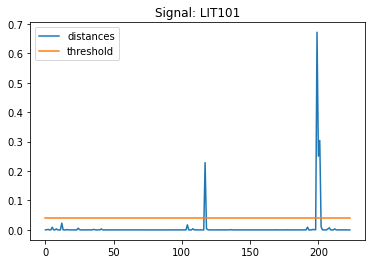

In [71]:
# distance of each data point from its nearest neighbor

plt.plot(distances, label='distances')
plt.plot(range(len(distances)), np.array([THRESHOLD] * len(distances)), label='threshold')
plt.title('Signal: LIT101')
plt.legend()
plt.show()

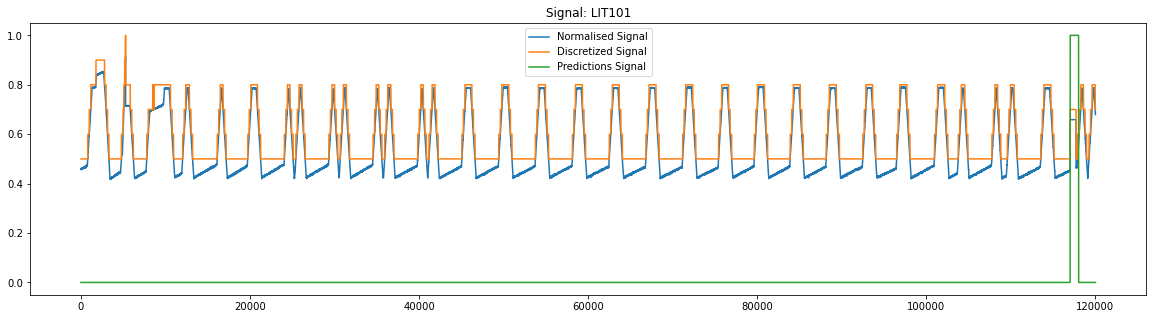

In [72]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(norm_signal_v[:120000], label='Normalised Signal')
ax.plot(discrete_signal_v[:120000], label='Discretized Signal')
ax.plot(pred_signal[:120000], label='Predictions Signal')

plt.title('Signal: LIT101')
plt.legend()
plt.show()

In [73]:
# hyperparameters for 'LIT101' with differencing

N = 4 
LEVELS = 10
WINDOW = 100
OVERLAP = 0
THRESHOLD = 0.03 # decided based on the nearest neighbor distance plot found below
QUANTILES = 'linspace' # can be 'linspace' or 'percentiles'

In [74]:
# Apply differencing for train set

signal = train_df[['LIT101']]
signal['Diff'] = signal['LIT101'].diff()
signal = signal.fillna(0)

signal= signal[['Diff']].values
signal = signal.reshape(-1)

norm_signal, coded_signal, discrete_signal, _ = discretise(signal, quantiles=QUANTILES, levels=LEVELS)

signature = calc_freq(coded_signal, window=WINDOW, overlap=OVERLAP, n=N)

In [75]:
# Apply differencing for validation set

val_signal = val_df[['LIT101']]
val_signal['Diff'] = val_signal['LIT101'].diff()
val_signal = val_signal.fillna(0)

val_signal = val_signal[['Diff']].values
val_signal = val_signal.reshape(-1)

norm_signal_v, coded_signal_v, discrete_signal_v, _ = discretise(val_signal, quantiles=QUANTILES, is_train = False, levels=LEVELS)

val_signature = calc_freq(coded_signal_v, is_train = False, window=WINDOW, overlap=OVERLAP, n=N)

In [76]:
# get predictions

pred_signal = np.zeros(len(val_signal))
distances, pred_signal = predictions(signature, val_signature, pred_signal, threshold = THRESHOLD)

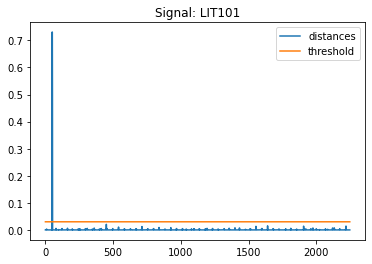

In [77]:
# distance of each data point from its nearest neighbor

plt.plot(distances, label='distances')
plt.plot(range(len(distances)), np.array([THRESHOLD] * len(distances)), label='threshold')
plt.title('Signal: LIT101')
plt.legend()
plt.show()

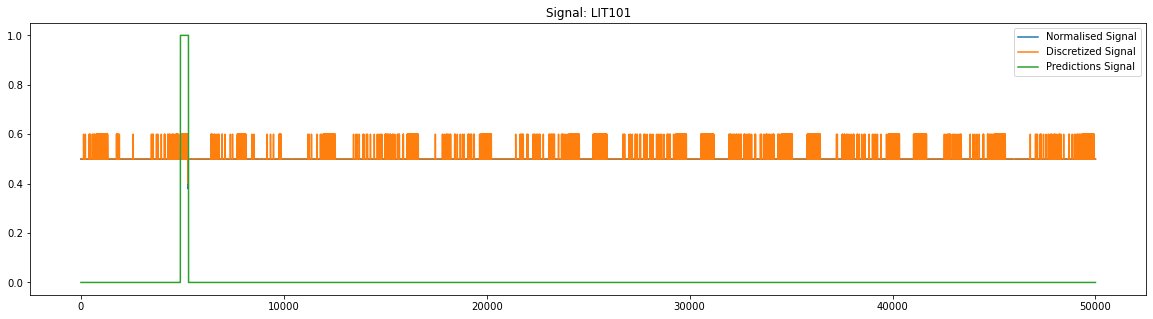

In [78]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(norm_signal_v[:50000], label='Normalised Signal')
ax.plot(discrete_signal_v[:50000], label='Discretized Signal')
ax.plot(pred_signal[:50000], label='Predictions Signal')

plt.title('Signal: LIT101')
plt.legend()
plt.show()

#### Signal: FIT301

In [79]:
# hyperparameters for 'FIT301'

N = 4 
LEVELS = 10
WINDOW = 1000
OVERLAP = 0
THRESHOLD = 0.015 # decided based on the nearest neighbor distance plot found below
QUANTILES = 'linspace' # can be 'linspace' or 'percentiles'

In [80]:
# train set

signal = train_df[['FIT301']].values
signal = signal.reshape(-1)

norm_signal, coded_signal, discrete_signal, _ = discretise(signal, quantiles=QUANTILES,  levels=LEVELS)

signature = calc_freq(coded_signal, window=WINDOW, overlap=OVERLAP, n=N)

In [81]:
# table showing windows in rows and ngrams in columns

signature.head() # only head printed for efficiency

,aaaa,baaa,bbaa,cbba,ecbb,fecb,gfec,igfe,jigf,jjig,...,ihgd,fccb,gfcc,igfc,ggdc,iggd,deff,effh,degi,egii
0,794.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,934.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,107.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# validation set

val_signal = val_df[['FIT301']].values
val_signal = val_signal.reshape(-1)

norm_signal_v, coded_signal_v, discrete_signal_v, _ = discretise(val_signal, quantiles=QUANTILES, is_train = False, levels=LEVELS)

val_signature = calc_freq(coded_signal_v, is_train = False, window=WINDOW, overlap=OVERLAP, n=N)

In [83]:
# table showing windows in rows and ngrams in columns

val_signature.head() # only head printed for efficiency

,aaaa,baaa,bbaa,cbba,ecbb,fecb,gfec,igfe,jigf,jjig,...,ihgd,fccb,gfcc,igfc,ggdc,iggd,deff,effh,degi,egii
0,278.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,43.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
# get predictions

pred_signal = np.zeros(len(val_signal))
distances, pred_signal = predictions(signature, val_signature, pred_signal, threshold = THRESHOLD)

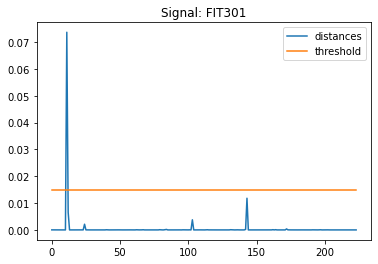

In [85]:
# distance of each data point from its nearest neighbor

plt.plot(distances, label='distances')
plt.plot(range(len(distances)), np.array([THRESHOLD] * len(distances)), label='threshold')
plt.title('Signal: FIT301')
plt.legend()
plt.show()

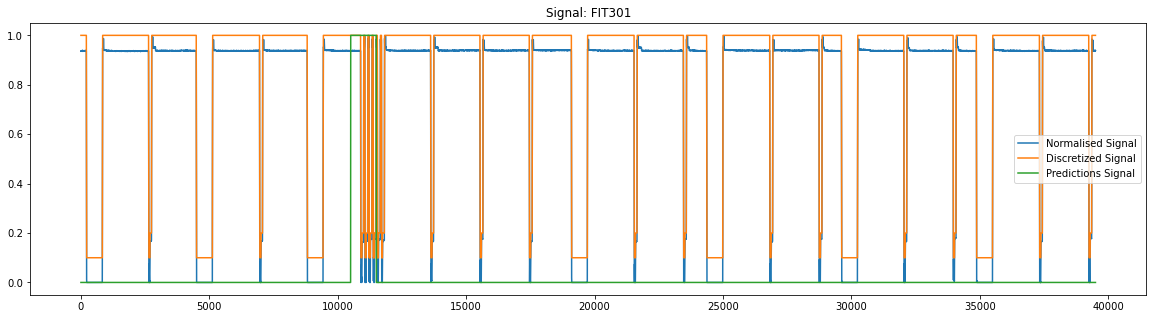

In [86]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(norm_signal_v[500:40000], label='Normalised Signal')
ax.plot(discrete_signal_v[500:40000], label='Discretized Signal')
ax.plot(pred_signal[500:40000], label='Predictions Signal')

plt.title('Signal: FIT301')
plt.legend()
plt.show()

In [87]:
# hyperparameters for 'FIT301' with differencing

N = 4 
LEVELS = 10
WINDOW = 1000
OVERLAP = 0
THRESHOLD = 0.0006 # decided based on the nearest neighbor distance plot found below
QUANTILES = 'linspace' # can be 'linspace' or 'percentiles'

In [88]:
# Apply differencing for train set

signal = train_df[['FIT301']]
signal['Diff'] = signal['FIT301'].diff()
signal = signal.fillna(0)

signal= signal[['Diff']].values
signal = signal.reshape(-1)

norm_signal, coded_signal, discrete_signal, _ = discretise(signal, quantiles=QUANTILES, levels=LEVELS)

signature = calc_freq(coded_signal, window=WINDOW, overlap=OVERLAP, n=N)

In [89]:
# Apply differencing for validation set

val_signal = val_df[['FIT301']]
val_signal['Diff'] = val_signal['FIT301'].diff()
val_signal = val_signal.fillna(0)

val_signal = val_signal[['Diff']].values
val_signal = val_signal.reshape(-1)

norm_signal_v, coded_signal_v, discrete_signal_v, _ = discretise(val_signal, quantiles=QUANTILES, is_train = False, levels=LEVELS)

val_signature = calc_freq(coded_signal_v, is_train = False, window=WINDOW, overlap=OVERLAP, n=N)

In [90]:
# get predictions

pred_signal = np.zeros(len(val_signal))
distances, pred_signal = predictions(signature, val_signature, pred_signal, threshold = THRESHOLD)

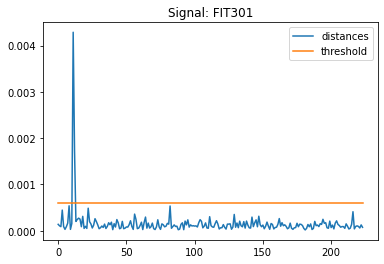

In [91]:
# distance of each data point from its nearest neighbor

plt.plot(distances, label='distances')
plt.plot(range(len(distances)), np.array([THRESHOLD] * len(distances)), label='threshold')
plt.title('Signal: FIT301')
plt.legend()
plt.show()

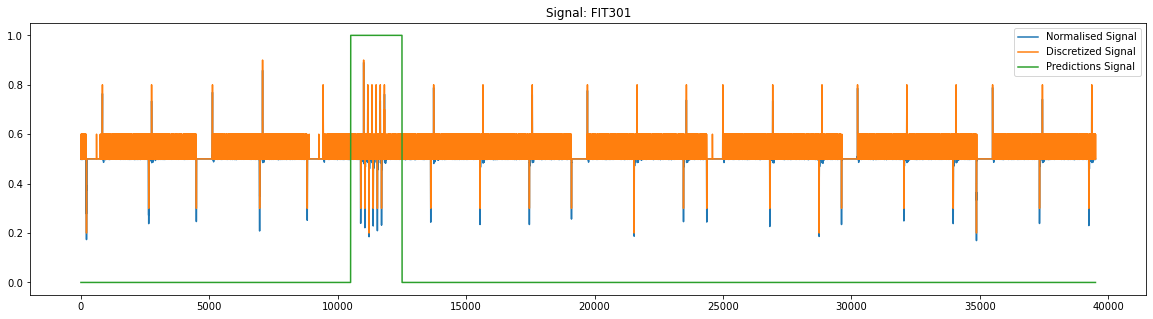

In [92]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(norm_signal_v[500:40000], label='Normalised Signal')
ax.plot(discrete_signal_v[500:40000], label='Discretized Signal')
ax.plot(pred_signal[500:40000], label='Predictions Signal')

plt.title('Signal: FIT301')
plt.legend()
plt.show()

### 5b. Analysis and answers to the questions. Also provide relevant plots.

**1. Does differencing improve performance? Explain** Differencing does help in better localising the anomalous data point. Stationary time series data is easier to map due to less variance in the data. Differencing allows to convert a signal to a stationary time series and hence improves performance.

**2. What kind of anomalies can you detect?** N-Gram can be used to detect *contextual anomalies* where is point is considered anomalous in a particular context.

**3. Which kind of sensors can be modeled effectively using N-grams?** Signals with cyclic behaviours can be modelled effectively with N-Grams as it is translation and scale invariant.

In [93]:
# Multi-variate performance

# hyperparameters for multivariate
N = 4 
LEVELS = 10
WINDOW = 1000
OVERLAP = 500
THRESHOLD = 98 # threshold is 98 percentile
DERIVE_THRESHOLD = True
QUANTILES = 'linspace' # can be 'linspace' or 'percentiles'

In [94]:
def multivariate_predict(train_dataframe, test_dataframe, chk_perf=True, column_list=None):
    '''
    predicts labels based on each signal
    '''
    
    pred_per_col = {}
    metric_per_col = {}
    
    for col in tqdm(column_list):
        
        # train set
        
        signal = train_dataframe[[col]]
        signal['Diff'] = signal[col].diff()
        signal = signal.fillna(0)

        signal= signal[['Diff']].values
        signal = signal.reshape(-1)

        _, coded_signal, _, is_failed = discretise(signal, quantiles=QUANTILES, is_train = True, levels=LEVELS)
        
        if is_failed:
            continue

        signature = calc_freq(coded_signal, window=WINDOW, overlap=OVERLAP, n=N)
        
        # validation set

        val_signal = test_dataframe[[col]]
        val_signal['Diff'] = val_signal[col].diff()
        val_signal = val_signal.fillna(0)

        val_signal= val_signal[['Diff']].values
        val_signal = val_signal.reshape(-1)

        _, coded_signal_v, _, is_failed = discretise(val_signal, quantiles=QUANTILES, is_train = False, levels=LEVELS)

        val_signature = calc_freq(coded_signal_v, is_train = False, window=WINDOW, overlap=OVERLAP, n=N)
        
        # get predictions

        pred_signal = np.zeros(len(val_signal))
        _, pred_signal = predictions(signature, 
                                     val_signature, 
                                     pred_signal, 
                                     threshold = THRESHOLD, 
                                     derive_threshold = DERIVE_THRESHOLD)
        
        pred_per_col[col] = pred_signal
        
        if chk_perf:
            metric_per_col[col] = {}
            _, fp, _, tp = confusion_matrix(test_dataframe.Label, pred_signal).ravel()

            metric_per_col[col]['fp'] = fp
            metric_per_col[col]['tp'] = tp
            metric_per_col[col]['F1'] = f1_score(test_dataframe.Label, pred_signal)
            metric_per_col[col]['Precision'] = precision_score(test_dataframe.Label, pred_signal)
            metric_per_col[col]['Recall'] = recall_score(test_dataframe.Label, pred_signal)
            metric_per_col[col]['Accuracy'] = accuracy_score(test_dataframe.Label, pred_signal)
        
    return pd.DataFrame(pred_per_col), pd.DataFrame(metric_per_col)

In [95]:
preds, perf = multivariate_predict(train_df, val_df, column_list=sensors)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:27<00:00,  1.71s/it]


In [96]:
# Aggregate results such that if atleast one of the signal states anomaly the datapoint is marked anomalous 

max_pred = preds.aggregate('max', axis=1)

_, fp, _, tp = confusion_matrix(val_df.Label, max_pred).ravel()

# Performance Metrics
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'F1: {f1_score(val_df.Label, max_pred)}')
print(f'Precision: {precision_score(val_df.Label, max_pred)}')
print(f'Recall: {recall_score(val_df.Label, max_pred)}')
print(f'Accuracy: {accuracy_score(val_df.Label, max_pred)}')

True Positives: 6923
False Positives: 104577
F1: 0.11299536462753802
Precision: 0.06208968609865471
Recall: 0.6273106197897789
Accuracy: 0.5168452918087296


## 6.Comparision task 

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

From the given instructions we try to evaluate the performance of the above implemented four methods (LOF, PCA, AR and N-gram model) on the basis of F1 score which is a combination of precision and recall. F1 has been chosen consciously as the comparison matrix because the classes anomolous and non-anomolous are unbalanced and there is a serious downside in predicting false negatives in SCADA systems. 

Below are the scores for all the four methods (F1 = 2 x precision x recall / (precision + recall)), based on which we make our comparisons.

LOF: 0.58 (Could vary due to random sampling of data points)

PCA: 0.23

AR:  0.10

N-gram: 0.11

**LOF**: LOF relies on the local deviation of density of a sample with respect to its neighbours to predict whether a point is outlier or inlier. As it depends on its local neighbourhood, the number of neighbours or the parameter k is critical. However, as the method requires a long time for execution, we could not tune the parameter. Additionally the performance is measure on a sample dataset and hence cannot be truely compared to the rest of the methods

**PCA**: As PCA ia a dimentionality reduction technique which tries to capture majority of the variance in data, we used 20 components instead of the 51 sensors given in the dataset as with only 20 components, almost 99% of the variance in data could be captured. In our implementation, we got 0.15 as the F1 score. On further trying to optimize the max min thresholds and deleting top 10 anomalous points from the training data, F1 bounced to 0.23. Therefore, PCA can prove to be very useful for anomaly detection if more effort is put in hyper parameter tuning.

**Regression**: Auto Regression model takes the values of previous timestamps to predict the future value thereby incorporates context and is helpful in predicting Contexual Anomalies. In our implmentation, we have marked a record as anomolous if any of the 51 sensors predicts it to be an anomoly and have used mean ± 2*std deviation as a threshold. Using this we got an F1 score of 0.10. This might not be the best implementation as the threshold values for every signal might not be correctly represented by the formula we used. Therefore, probably the domain experts who have prior knowledge about these sensors, actuators and are aware of their sensitivity might be able to use this technique fruitfully.

**N-gram**: In the N-gram method, signals are converted into discrete symbols and anomaly is predicted with the help of frequency of a ngram within a window. There are a lot of parameters that require joint optimisation such as N for the Ngram, size of the window and the threshold for each of the signals. Due to limitation in time and complexity of joint optimization, they are not tuned. The thresholds are decided for the individual signal analysis sections depending on the distances. However, it could not be optimised for all the 51 signals and we decided to use the 98 percentile corresponding to each signal as the threshold for the multivariate scenario.



## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.

## 8. Kaggle Submission

In [97]:
scaling = StandardScaler()
scaling.fit(train_df.drop(columns=['Id', 'Timestamp', 'Label'], axis = 1))
scaled_train_data = scaling.transform(train_df.drop(columns=['Id', 'Timestamp', 'Label'], axis = 1))
scaled_val_data = scaling.transform(val_df.drop(columns=['Id', 'Timestamp', 'Label'], axis = 1))

pca = PCA(n_components=0.9) # select components that can explain 90% of the variance
pca.fit(scaled_train_data)

train_pca = pca.transform(scaled_train_data)
train_pca_df = pd.DataFrame(train_pca)

val_pca = pca.transform(scaled_val_data)
val_pca_df = pd.DataFrame(val_pca)
val_pca_df = pd.concat([val_pca_df.reset_index(drop=True),
                       val_df[['Label']].reset_index(drop=True)],
                      axis = 1)

In [98]:
preds, perf = multivariate_predict(train_pca_df, val_pca_df, column_list=train_pca_df.columns)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


In [99]:
# Aggregate results such that if atleast one of the signal states anomaly the datapoint is marked anomalous 

max_pred = preds.aggregate('max', axis=1)

_, fp, _, tp = confusion_matrix(val_df.Label, max_pred).ravel()

# Performance Metrics
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'F1: {f1_score(val_df.Label, max_pred)}')
print(f'Precision: {precision_score(val_df.Label, max_pred)}')
print(f'Recall: {recall_score(val_df.Label, max_pred)}')
print(f'Accuracy: {accuracy_score(val_df.Label, max_pred)}')

True Positives: 6823
False Positives: 35677
F1: 0.2548939031679618
Precision: 0.16054117647058824
Recall: 0.6182493657122146
Accuracy: 0.8226787992478629


In [100]:
scaled_test_data = scaling.transform(test_df.drop(columns=['Id', 'Timestamp'], axis = 1))

test_pca = pca.transform(scaled_test_data)
test_pca_df = pd.DataFrame(test_pca)

In [101]:
preds, _ = multivariate_predict(train_pca_df, test_pca_df, chk_perf=False, column_list=train_pca_df.columns)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


In [102]:
# Aggregate results such that if atleast one of the signal states anomaly the datapoint is marked anomalous 

max_pred = preds.aggregate('max', axis=1)
max_pred = pd.concat([max_pred.reset_index(drop=True), 
                      test_df[['Id']].reset_index(drop=True)],
                     axis = 1)
max_pred = max_pred.rename({'index': 'Id', 0: 'Label'}, axis=1) 
max_pred = max_pred[['Id', 'Label']]
max_pred['Label'] = max_pred['Label'].astype(int)

In [104]:
max_pred.to_csv('data/submission.csv', index=False)

#!cp 'data/submission.csv' '/content/drive/MyDrive/Colab Notebooks/CDA'